Universidade Federal de Alagoas

IC - Instituto de Computação

# Processamento de linguagem natural - 2020.1

**Professor**: Thales Vieira

**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior

## 3ª lista de exercícios

---

In [1]:
%%html
<style>
    a:link, a:visited {
        color: white;
        font-weight: bold;
        text-decoration: underline;
    }
    code {
        padding: 2px;
        color: blue;
    }
    .w-half {
        width: 50%;
    }
    .left {
        float: left;
    }
    .right {
        float: right;
    }
    .col {
        height: 100%;
        padding-left: 16px;
        padding-right: 16px;
        padding-top: 8px;
        padding-bottom: 8px;

    }
    .better {
        color: white;
        background-color: #5cb85c;
    }
    .worse {
        color: black;
        background-color: ;
    }
</style>

<div style="color: #856404; background-color: #ffeeba; padding: 16px; border: 1px solid transparent; border-radius: .25rem">
    ⚠️ O <code>jupyter</code> deve ser iniciado no diretório que contém a pasta <code>data</code>
</div>

In [2]:
import re
import nltk
import numpy
import pandas
import random

from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Os Dados
Notícias dos sites www.bbc.co.uk (350) e www.cnn.com.br (1275) sobre o novo coronavírus. Cada arquivo contém as seguintes colunas:
- ```url```: Endereço da notícia
- ```title```: Título da notícia
- ```text```: Texto da notícia

As colunas são separadas por `|`

In [3]:
# Carregando dados
bbc = pandas.read_csv('data/bbc.csv', sep='|')
bbc['label'] = 'BBC'
cnn = pandas.read_csv('data/cnn.csv', sep='|')
cnn['label'] = 'CNN'
cnn = cnn.dropna(axis=0)
dataset = pandas.concat([bbc, cnn], ignore_index=True)

# Limpeza
def remove_boilerplate(text):
    boilerplate = ['Compartilhe este post com Email Facebook Messenger Messenger Twitter WhatsApp LinkedIn Copiar este link Estes são links externos e abrirão numa nova janela', 'Já assistiu aos nossos novos vídeos no YouTube? Inscreva-se no nosso canal!', 'Final de YouTube post  de BBC News Brasil Final de YouTube post 2 de BBC News Brasil Final de YouTube post 3 de BBC News Brasil']
    
    for b in boilerplate:
        text = text.replace(b, '')

    return text

stopwords = nltk.corpus.stopwords.words('portuguese')

def remove_stopwords(text):
    tokenized_text = nltk.word_tokenize(text, language='portuguese')
    return " ".join([token for token in tokenized_text if token not in stopwords])

def preprocess_rawtext(rawtext):
    rawtext = re.sub(r'\w*\d\w*', '', rawtext) # remove todas as palavras que contém números
    rawtext = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ ]', '', rawtext.lower()) # remove pontuação e converte para minúscula
    return re.sub(r'\s+', ' ', rawtext) # remove espaços repetidos

dataset.replace(numpy.nan, '', inplace=True)
dataset.text = dataset.text.apply(lambda text: text.replace('\n', ' '))
dataset.text = dataset.text.apply(remove_boilerplate)
dataset.text = dataset.text.apply(preprocess_rawtext)
dataset.text = dataset.text.apply(remove_stopwords)
dataset.text = dataset.text.apply(lambda text: text.replace('bbc', '').replace('cnn', '')) # deixando a classificação justa

dataset.head(5)

,url,title,text,label
0,https://www.bbc.co.uk/portuguese/brasil-53020785,Coronavírus: pandemia pode jogar até 14 milhõe...,turbulência econômica causada pandemia novo co...,BBC
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas co...,cerca mil voluntários brasileiros vão receber ...,BBC
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se t...,atualizada s junho brasil totalizou nesta sext...,BBC
3,https://www.bbc.co.uk/portuguese/internacional...,Coronavírus na Índia: com lockdown 'insustentá...,março governo indiano iniciou estrito isolamen...,BBC
4,https://www.bbc.co.uk/portuguese/internacional...,2ª onda do coronavírus? Irã vê aumento acelera...,irã registrou rápido aumento número casos covi...,BBC


In [4]:
tfidf_X = TfidfVectorizer().fit_transform(dataset.text)
count_X = CountVectorizer().fit_transform(dataset.text)

tfidf_similarity_matrix = cosine_similarity(tfidf_X)
count_similarity_matrix = cosine_similarity(count_X)

numpy.fill_diagonal(tfidf_similarity_matrix, 0.0)
numpy.fill_diagonal(count_similarity_matrix, 0.0)

result = [
    {
        'doc': dataset.iloc[i],
        'tfidf_similar_doc': dataset.iloc[tfidf_similarity_matrix[i, :].argmax()],
        'tfidf_similarity': tfidf_similarity_matrix[i, :].max(),
        'count_similar_doc': dataset.iloc[count_similarity_matrix[i, :].argmax()],
        'count_similarity': count_similarity_matrix[i, :].max(),
    }
    for i in [random.randint(0, len(dataset)) for _ in range(10)]
]    

In [5]:
for r in result:
    header = r['doc'].title if r['doc'].title != '' else r['doc'].text[:140] + '...'
    news_content = '<a href="%(link)s">%(title)s</a> <span>%(head)s</span>'
    result_class = lambda vectorizer, r: 'better' if r[vectorizer + '_similarity'] > r[('tfidf' if vectorizer == 'count' else 'count') + '_similarity'] else 'worse' 
    head_length = 280
    
    tfidf_content = news_content % ({
        'link': r['tfidf_similar_doc'].url, 
        'title':  r['tfidf_similar_doc'].url if r['tfidf_similar_doc'].title == '' else r['tfidf_similar_doc'].title,
        'head': r['tfidf_similar_doc'].text[:head_length] + '...',
    })
    count_content = news_content % ({
        'link': r['count_similar_doc'].url, 
        'title':  r['count_similar_doc'].url if r['count_similar_doc'].title == '' else r['count_similar_doc'].title,
        'head': r['count_similar_doc'].text[:head_length] + '...',
    })
    
    
    display(HTML('''
    <div style="margin: 8px; border: 1px solid lightgray">
        <div style="text-align: center;background-color: whitesmoke;padding: 8px"><a href="''' + r['doc'].url + '''">''' + header + '''</a></div>
        <div>
            <div class="left w-half">
                <div class="col ''' + result_class('tfidf', r) + '''">
                    <div><strong>TfidfVectorizer: </strong>''' + str(r['tfidf_similarity'])[:6] + '''</div>
                    <div>''' + tfidf_content + '''</div>
                </div>
            </div>
            <div class="right w-half">
                <div class="col ''' + result_class('count', r) + '''">
                <div><strong>CountVectorizer: </strong>''' + str(r['count_similarity'])[:6] + '''</div>
                <div>''' + count_content + '''</div>
                </div>
            </div>
        </div>
    </div>
    '''))

# Classificadores

Balanceando o dataset para conter 350 artigos _BBC_ e 350 artigos _CNN_ (700 artigos no total):

In [6]:
tfidf_X = tfidf_X[:2*bbc.shape[0]]
count_X = count_X[:2*bbc.shape[0]]

In [7]:
label2index = {
    'BBC': 0, 'CNN': 1
}
y = [label2index[l] for l in dataset.label.values[:700]]

Separando o conjunto de treinamento e teste:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, test_size=.3)
count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(count_X, y, test_size=.3)

Treinando os classificadores:

### Regressão Logística

In [10]:
from sklearn.linear_model import LogisticRegression

Treinamento (TF-IFD):

In [11]:
classifier = LogisticRegression().fit(tfidf_X_train.toarray(), tfidf_y_train)

Resultado da predição (TF-IDF):

In [12]:
tfidf_y_pred = classifier.predict(tfidf_X_test.toarray())

Matriz de confusão (TF-IDF):

In [13]:
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix

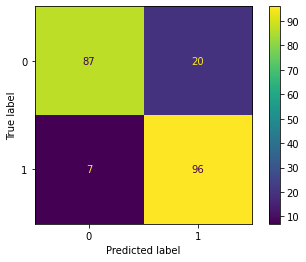

In [14]:
plot_confusion_matrix(classifier, tfidf_X_test.toarray(), tfidf_y_test)
pyplot.show()

Métricas de validação (TF-IDF):

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
log_tfidf_metrics = {
    'Modelo': 'Regressão Logísitca + TF-IDF',
    'Acurácia': accuracy_score(tfidf_y_test, tfidf_y_pred),
    'Precisão': precision_score(tfidf_y_test, tfidf_y_pred),
    'Recall': recall_score(tfidf_y_test, tfidf_y_pred),
    'F1 Score': f1_score(tfidf_y_test, tfidf_y_pred)
}
log_tfidf_metrics

{'Modelo': 'Regressão Logísitca + TF-IDF',
 'Acurácia': 0.8714285714285714,
 'Precisão': 0.8275862068965517,
 'Recall': 0.9320388349514563,
 'F1 Score': 0.8767123287671234}

Treinamento (Count Vectorizer):

In [17]:
classifier = LogisticRegression().fit(count_X_train.toarray(), count_y_train)

Resultado da predição (Count Vectorizer):

In [18]:
count_y_pred = classifier.predict(count_X_test.toarray())

Matriz de confusão (Count Vectorizer):

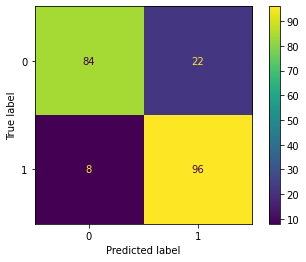

In [19]:
plot_confusion_matrix(classifier, count_X_test.toarray(), count_y_test)
pyplot.show()

Métricas de validação (Count Vectorizer):

In [20]:
log_count_metrics = {
    'Modelo': 'Regressão Logísitca + Count Vectorizer',
    'Acurácia': accuracy_score(count_y_test, count_y_pred),
    'Precisão': precision_score(count_y_test, count_y_pred),
    'Recall': recall_score(count_y_test, count_y_pred),
    'F1 Score': f1_score(count_y_test, count_y_pred)
}
log_count_metrics

{'Modelo': 'Regressão Logísitca + Count Vectorizer',
 'Acurácia': 0.8571428571428571,
 'Precisão': 0.8135593220338984,
 'Recall': 0.9230769230769231,
 'F1 Score': 0.8648648648648649}

### Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

Treinamento (TF-IFD):

In [22]:
classifier = MultinomialNB().fit(tfidf_X_train.toarray(), tfidf_y_train)

Resultado da predição (TF-IDF):

In [23]:
tfidf_y_pred = classifier.predict(tfidf_X_test.toarray())

Matriz de confusão (TF-IDF):

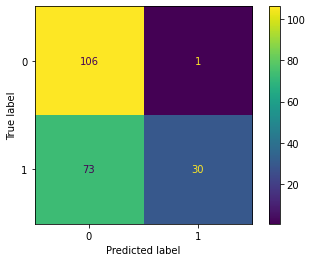

In [24]:
plot_confusion_matrix(classifier, tfidf_X_test.toarray(), tfidf_y_test)
pyplot.show()

Métricas de validação (TF-IDF):

In [25]:
nai_tfidf_metrics = {
    'Modelo': 'Naive Bayes + TF-IDF',
    'Acurácia': accuracy_score(tfidf_y_test, tfidf_y_pred),
    'Precisão': precision_score(tfidf_y_test, tfidf_y_pred),
    'Recall': recall_score(tfidf_y_test, tfidf_y_pred),
    'F1 Score': f1_score(tfidf_y_test, tfidf_y_pred)
}
nai_tfidf_metrics

{'Modelo': 'Naive Bayes + TF-IDF',
 'Acurácia': 0.6476190476190476,
 'Precisão': 0.967741935483871,
 'Recall': 0.2912621359223301,
 'F1 Score': 0.44776119402985076}

Treinamento (Count Vectorizer):

In [26]:
classifier = MultinomialNB().fit(count_X_train.toarray(), count_y_train)

Resultado da predição (Count Vectorizer):

In [27]:
count_y_pred = classifier.predict(count_X_test.toarray())

Matriz de confusão (Count Vectorizer):

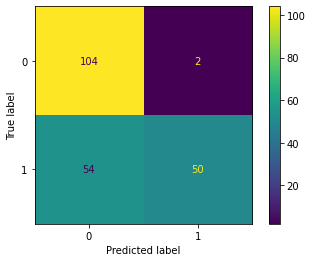

In [28]:
plot_confusion_matrix(classifier, count_X_test.toarray(), count_y_test)
pyplot.show()

Métricas de validação (Count Vectorizer):

In [29]:
nai_count_metrics = {
    'Modelo': 'Naive Bayes + Count Vectorizer',
    'Acurácia': accuracy_score(count_y_test, count_y_pred),
    'Precisão': precision_score(count_y_test, count_y_pred),
    'Recall': recall_score(count_y_test, count_y_pred),
    'F1 Score': f1_score(count_y_test, count_y_pred)
}
nai_count_metrics

{'Modelo': 'Naive Bayes + Count Vectorizer',
 'Acurácia': 0.7333333333333333,
 'Precisão': 0.9615384615384616,
 'Recall': 0.4807692307692308,
 'F1 Score': 0.6410256410256411}

### Support Vector Machines (SVM)

Treinamento (TF-IFD):

In [30]:
from sklearn.svm import SVC

In [31]:
classifier = SVC().fit(tfidf_X_train.toarray(), tfidf_y_train)

Resultado da predição (TF-IDF):

In [32]:
tfidf_y_pred = classifier.predict(tfidf_X_test.toarray())

Matriz de confusão (TF-IDF):

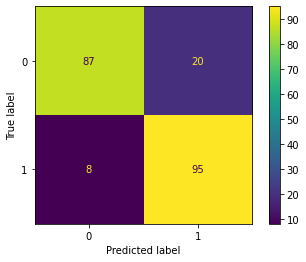

In [33]:
plot_confusion_matrix(classifier, tfidf_X_test.toarray(), tfidf_y_test)
pyplot.show()

Métricas de validação (TF-IDF):

In [35]:
svm_tfidf_metrics = {
    'Modelo': 'SVM + TF-IDF',
    'Acurácia': accuracy_score(tfidf_y_test, tfidf_y_pred),
    'Precisão': precision_score(tfidf_y_test, tfidf_y_pred),
    'Recall': recall_score(tfidf_y_test, tfidf_y_pred),
    'F1 Score': f1_score(tfidf_y_test, tfidf_y_pred)
}
svm_tfidf_metrics

{'Modelo': 'SVM + TF-IDF',
 'Acurácia': 0.8666666666666667,
 'Precisão': 0.8260869565217391,
 'Recall': 0.9223300970873787,
 'F1 Score': 0.8715596330275228}

Treinamento (Count Vectorizer):

In [36]:
classifier = SVC().fit(count_X_train.toarray(), count_y_train)

Resultado da predição (Count Vectorizer):

In [37]:
count_y_pred = classifier.predict(count_X_test.toarray())

Matriz de confusão (Count Vectorizer):

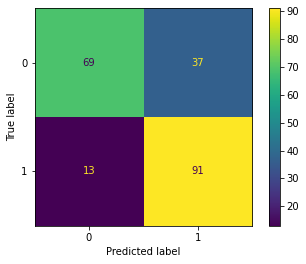

In [38]:
plot_confusion_matrix(classifier, count_X_test.toarray(), count_y_test)
pyplot.show()

Métricas de validação (Count Vectorizer):

In [39]:
svm_count_metrics = {
    'Modelo': 'SVM + Count Vectorizer',
    'Acurácia': accuracy_score(count_y_test, count_y_pred),
    'Precisão': precision_score(count_y_test, count_y_pred),
    'Recall': recall_score(count_y_test, count_y_pred),
    'F1 Score': f1_score(count_y_test, count_y_pred)
}
svm_count_metrics

{'Modelo': 'SVM + Count Vectorizer',
 'Acurácia': 0.7619047619047619,
 'Precisão': 0.7109375,
 'Recall': 0.875,
 'F1 Score': 0.7844827586206896}

Comparando os classificadores:

In [41]:
pandas.DataFrame([log_tfidf_metrics, log_count_metrics, nai_tfidf_metrics, nai_count_metrics, svm_tfidf_metrics, svm_count_metrics])

,Modelo,Acurácia,Precisão,Recall,F1 Score
0,Regressão Logísitca + TF-IDF,0.871429,0.827586,0.932039,0.876712
1,Regressão Logísitca + Count Vectorizer,0.857143,0.813559,0.923077,0.864865
2,Naive Bayes + TF-IDF,0.647619,0.967742,0.291262,0.447761
3,Naive Bayes + Count Vectorizer,0.733333,0.961538,0.480769,0.641026
4,SVM + TF-IDF,0.866667,0.826087,0.922330,0.871560
5,SVM + Count Vectorizer,0.761905,0.710938,0.875000,0.784483
